In [156]:
#import user modules
import utils.helper_functions as hfun
import config as cf
import modules.thouless_times as thouless
import modules.spectral_functions as spec_fun
import modules.sff as sff_module
import modules.adiabatics as agp
import modules.anderson as anderson
import importlib
from utils.fit_functions import *
def reload_modules():
    importlib.reload(anderson)
    importlib.reload(hfun)
    importlib.reload(cf)
    importlib.reload(thouless)
    importlib.reload(spec_fun)
    importlib.reload(agp)
    importlib.reload(sff_module)

reload_modules()

from utils.fit_functions import *

#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import scienceplots
import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use(['science', 'no-latex'])
%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')


../results/QUANTUM_SUN/disorder/


### GAP RATIO AND CHAOTIC STATISTICS

../results/QUANTUM_SUN/disorder/STATISTICS/_L=16,J=1.00,J0=0.20,g0=0.00,h=1.00,w=0.50.dat


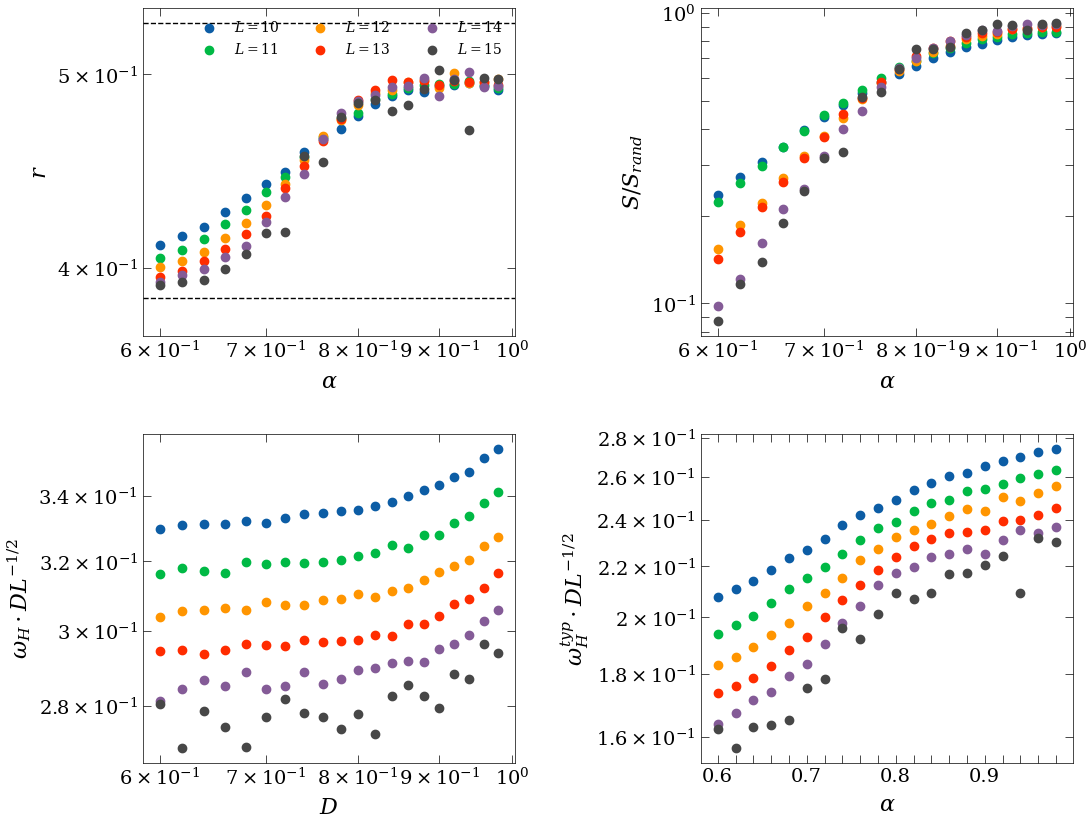

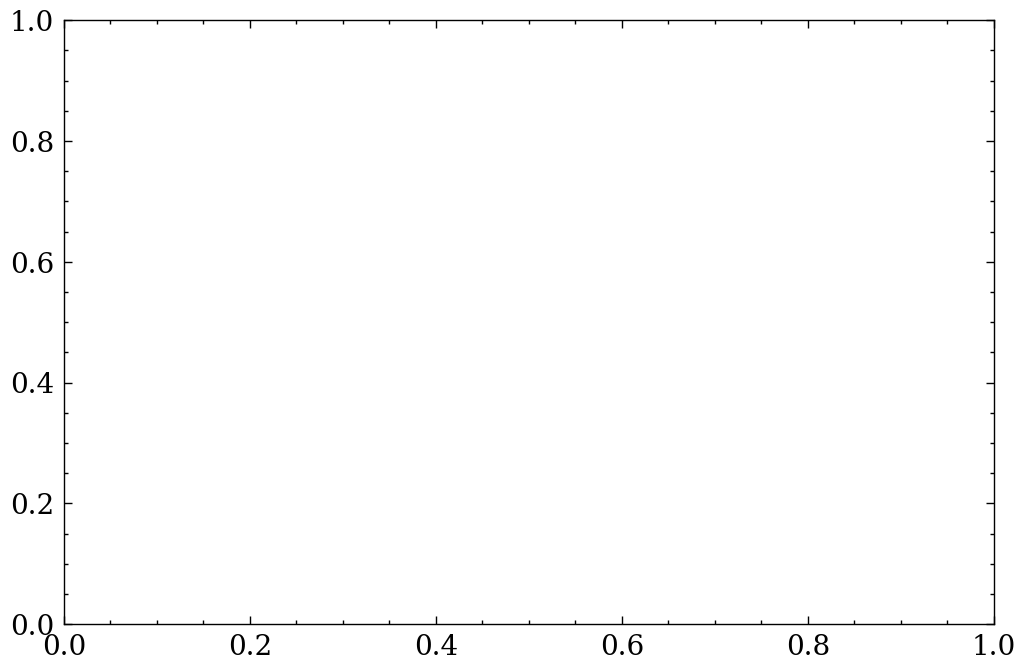

In [168]:
reload_modules()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,10), dpi = 100)

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs('g')
new_set_class.set_scaling("L")
new_set_class.set_scales(xscale='log', yscale='log')
settings = getattr(new_set_class, 'settings')

alfa = []
error_bars = []

param_copy = copy.deepcopy(cf.params_arr)
vals = None
if settings['scaling_idx'] == 2:
    vals = [0.0011, 0.002, 0.01, 0.042, 0.11, 0.33, 0.44, 0.58]
elif settings['scaling_idx'] == 4:
    vals = [0.04, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    vals = hfun.get_scaling_array(settings, x0=0.02, xend=0.6, dx=0.02)
else:
    vals = hfun.get_scaling_array(settings)
for x in vals:
    cf.params_arr[settings['scaling_idx']] = x
    filename = cf.base_directory + "STATISTICS" + kPSep + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat" 
    if exists(filename):
        Ltmp = x if settings['scaling_idx'] == 0 else cf.L

        #stats = pd.read_table(filename, sep="\t", header=None)
        stats = hfun.read_python_saved_dat_file(filename)
        xdata = stats[0]
        dims = binom(xdata, xdata / 2)
        gap_ratio = stats[1]
        
        norm = 1.0  if settings['vs_idx'] == 0 else binom(Ltmp, Ltmp / 2.) / np.sqrt(Ltmp)
        wH = stats[5] * norm
        wH_typ = stats[6] * norm
        
        ipr = stats[2] * dims
        info_ent = stats[3]

        #pars, pcov = fit(f=power_law, 
        #        xdata=dims, 
        #        ydata=ipr)
        #print(x, *pars)
        ##alfa.append(pars[0])
        #alfa.append( np.log2(ipr[-1] / ipr[0]) / np.log2(dims[-1] / dims[0]) )
        #error_bars.append(np.sqrt(np.diag(pcov)[0]))

        norm_entropy = Ltmp * np.log(2) / 2. + (0.5 - np.log(2)) / 2. - 0.5
        entropy = stats[4] / norm_entropy
        
        ax1.scatter(xdata, gap_ratio, label=hfun.key_title(x, settings))
        ax2.scatter(xdata, entropy, label=hfun.key_title(x, settings))
        ax3.scatter(xdata, wH, label=hfun.key_title(x, settings))
        ax4.scatter(xdata, wH_typ, label=hfun.key_title(x, settings))
        #ax3.scatter(dims, ipr, label=hfun.key_title(x, settings))
        #aa = np.logspace(2, 5, 100)
        #ax3.plot(aa, power_law(aa, *pars), linestyle='--')
        #ax4.scatter(xdata, info_ent, label=hfun.key_title(x, settings))
    else:
        print(filename)

def wH_analitycal(L, delta, W):
    """Calculate analytical mean level spacing"""
    width = np.sqrt(L * ( (2. + delta**2) / 16. + W**2 / 12.))
    chi = 0.3413
    dim = binom(L, L/2) if cf.hamiltonian == 1 else 2**L
    return width / (dim * chi)

if False:
    if settings['vs_idx'] != 0:
        xx = np.logspace(-0.5, 0, 100)
        if settings['vs_idx'] == 2:     ax3.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.02 * wH_analitycal(cf.L, xx, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        else:                           ax3.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.02 * wH_analitycal(cf.L, cf.g, xx), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        if settings['vs_idx'] == 2:     ax4.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.2 * wH_analitycal(cf.L, xx, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        else:                           ax4.plot(xx, binom(cf.L, cf.L/2) / np.sqrt(cf.L) / 1.2 * wH_analitycal(cf.L, cf.g, xx), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
    else:
        xx = np.linspace(9, 19, 20)
        ax3.plot(xx, wH_analitycal(xx, cf.g, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")
        ax4.plot(xx, wH_analitycal(xx, cf.g, cf.w), linestyle='--', color='black', label=r"$\omega_H^{analitycal}$")


ax1.axhline(y=0.5307, ls='--', color='black')
ax1.axhline(y=0.3867, ls='--', color='black')
ylabels = ["r", "S/S_{rand}", "\\omega_H\\cdot DL^{-1/2}", "\\omega_H^{typ}\\cdot DL^{-1/2}" ]
#ylabels = ["r", "S/S_{rand}", "IPR", "S_{info}/(-0.48\\cdot D)" ]
for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    xlab = hfun.var_name if settings['vs_idx'] == 2 else settings['vs']
    if i == 2: xlab = "D"
    hfun.set_plot_elements(axis = ax, ylabel = ylabels[i], xlabel = xlab, settings=settings, 
                            font_size=14, set_legend=False, xlim=(None, None), ylim=(None, None))
    if settings['vs_idx'] == 0 and i != 2:
        ax.set_yscale('linear')
        ax.set_xscale('linear')
    
ax3.set_xscale('log')
ax4.set_xscale('linear')
ax1.legend(ncol=3)
ax1.set_ylim(0.37, 0.54)
#ax2.set_ylim(0.3, 1)\
fig.subplots_adjust(wspace=0.5, hspace=0.3)

fig, axis = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi = 200)
#axis.plot(vals, alfa)
#axis.errorbar(vals, alfa, yerr=error_bars, marker='o', color='black')

 #--- reset defaults
cf.params_arr = param_copy

### SPECTRAL FORM FACTOR

../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=14,J=1.00,J0=0.20,g=0.80,g0=0.00,h=1.00,w=0.50.dat [14.0, 1.0, 0.8, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=14,J=1.00,J0=0.20,g=0.81,g0=0.00,h=1.00,w=0.50.dat [14.0, 1.0, 0.81, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=14,J=1.00,J0=0.20,g=0.82,g0=0.00,h=1.00,w=0.50.dat [14.0, 1.0, 0.82, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=14,J=1.00,J0=0.20,g=0.83,g0=0.00,h=1.00,w=0.50.dat [14.0, 1.0, 0.83, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=14,J=1.00,J0=0.20,g=0.84,g0=0.00,h=1.00,w=0.50.dat [14.0, 1.0, 0.84, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=14,J=1.00,J0=0.20,g=0.86,g0=0.00,h=1.00,w=0.50.dat [14.0, 1.0, 0.86, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]


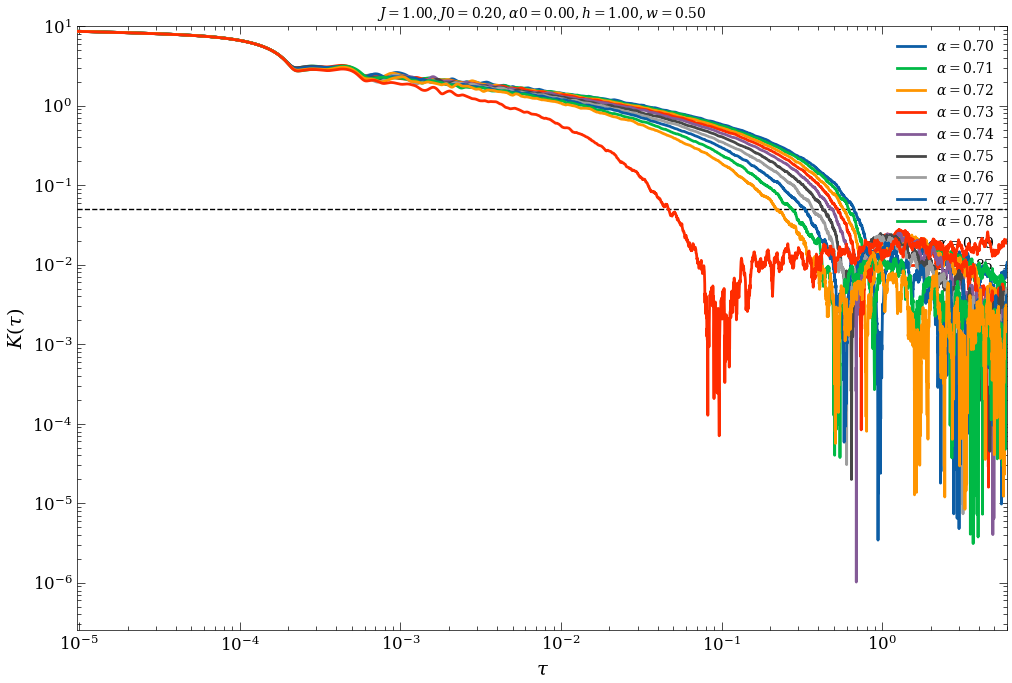

In [196]:
reload_modules()
user_settings = getattr(cf.plot_settings, 'settings')

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,8), dpi = 100)
def ehm_get_vals():
    return hfun.get_scaling_array(user_settings, 0.7, 0.86, 0.01) if user_settings['scaling_idx'] == 2 else hfun.get_scaling_array(user_settings, 0.05, 1., 0.05)
vals_sff = ehm_get_vals();
#vals_sff = [0.04, 0.1, 0.2, 0.3, 0.5]
plot_deviation = 1

if plot_deviation:
    sff_module.plot_deviation(axis=axis, vals=vals_sff)#, func_x = lambda x, a: x * np.exp(0.35*a) )
else:
    #axis.grid(b=True, which='major', color='0.65', linestyle='-')
    #axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    
    #width = 0.4
    #height= 0.4
    #left, bottom, width, height = [1 - width, 1 - height, width, height]
    #axis2 = hfun.add_subplot_axes(axis, [left, bottom, width, height])
    axis.axhline(y=0.38,ls='--', color='black', xmin=0.05, xmax=0.6)
    axis.axhline(y=1.0,ls=':', color='gray')
    sff_module.plot(axis=axis, vals=vals_sff, axis_inset=None, zoom = False, folded = False, func_x = lambda x, a: x * np.exp(0.33*a))
    #axis.set_ylim(1e-2,1e4)
    

In [199]:
reload_modules()
sizes = np.arange(10, 16, 1)
colors_ls_cyc = itertools.cycle(colors_ls)

vals_sff = ehm_get_vals();
taus = []
heisenberg_time = []
typical_time = []
facecolors = []
gap_ratio = []

param_copy = copy.deepcopy(cf.params_arr)
for L in sizes:
    tH = []
    tH_typ = []
    thouless_time = []
    fc = []
    gaps = []
    col = next(colors_ls_cyc)
    for x in vals_sff:
        cf.set_params(_L=L)
        cf.params_arr[user_settings['scaling_idx']] = x
        #print(cf.params_arr)
        status, times, sff, tH_tmp, tau, r_gap, dimensions = sff_module.load(settings=user_settings, parameter=x, folded = False)
        
        if status:
            tH_typ_tmp = 0
            filename = cf.base_directory + "STATISTICS" + kPSep + "raw_data" + kPSep + hfun.info_param(cf.params_arr)
            
            try:
                stats = hfun.load_stats(filename)
                #tH_tmp = 1. / stats['mean level spacing']
                #tH_typ_tmp = 1. / stats['typical level spacing']
            except FileNotFoundError:
                tH_typ_tmp = 0;
            gaps.append(r_gap)
            tau = tau * tH_tmp
            thouless_time.append(tau)
            tH.append(tH_tmp)
            tH_typ.append(tH_typ_tmp)

            if abs(r_gap - 0.5306) < 0.02:
                fc.append(col)
            else:
                fc.append('None')
        else:
            thouless_time.append(np.nan)
            tH.append(np.nan)
            tH_typ.append(np.nan)
            fc.append('None')
            gaps.append(np.nan)
    
    taus.append(np.array(thouless_time))
    facecolors.append(fc)
    heisenberg_time.append(np.array(tH))
    typical_time.append(np.array(tH_typ))
    gap_ratio.append(gaps)

#--- reset defaults
cf.params_arr = param_copy

../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=10,J=1.00,J0=0.20,g=0.80,g0=0.00,h=1.00,w=0.50.dat [10.0, 1.0, 0.8, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=10,J=1.00,J0=0.20,g=0.81,g0=0.00,h=1.00,w=0.50.dat [10.0, 1.0, 0.81, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=10,J=1.00,J0=0.20,g=0.82,g0=0.00,h=1.00,w=0.50.dat [10.0, 1.0, 0.82, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=10,J=1.00,J0=0.20,g=0.83,g0=0.00,h=1.00,w=0.50.dat [10.0, 1.0, 0.83, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=10,J=1.00,J0=0.20,g=0.84,g0=0.00,h=1.00,w=0.50.dat [10.0, 1.0, 0.84, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=10,J=1.00,J0=0.20,g=0.86,g0=0.00,h=1.00,w=0.50.dat [10.0, 1.0, 0.86, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=11,J=1.00,J0=0.20,g=0.80,g0=0.00,h=

10
11
12
13
14
15


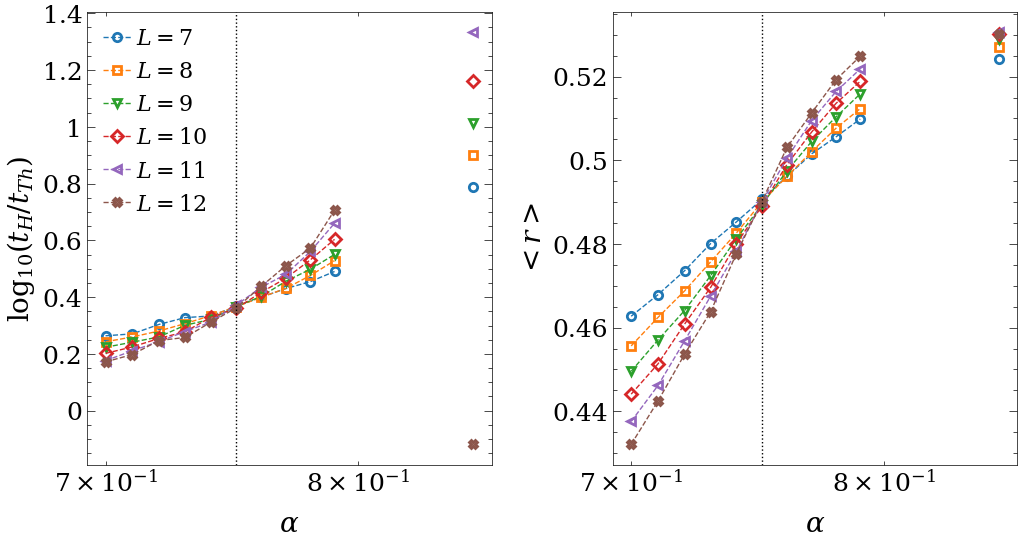

In [200]:
reload_modules()
markers = itertools.cycle(markers_ls)

label = "g_0" if user_settings['scaling_idx'] == 1 else ("\\alpha" if user_settings['scaling_idx'] == 2 else "\ ")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi = 100)

colors_ls_cyc = itertools.cycle(colors_ls)
for L in (sizes):
    jj = list(sizes).index(L)
    print(sizes[jj])
    col = next(colors_ls_cyc)

    G0 = np.log10(heisenberg_time[jj] / heisenberg_time[jj] / 1e-2)
    tau = np.log10(heisenberg_time[jj] / taus[jj])
    #tau = taus[jj]# / np.exp(0.353*L)
    mar = next(markers)

    axes[0].plot(vals_sff, tau,           color = col, markerfacecolor = 'None', lw = 1, marker=mar, markeredgewidth=2, ls='--', label=r"$L=%d$"%(L-3))
    axes[1].plot(vals_sff, gap_ratio[jj], color = col, markerfacecolor = 'None', lw = 1, marker=mar, markeredgewidth=2, ls='--', label=r"$L=%d$"%(L-3))
    #axis.scatter(vals_sff, heisenberg_time[jj], marker='s', color = col, s=10)

hfun.set_plot_elements(axis = axes[0], ylabel = "\log_{10}(t_H/t_{Th})", xlabel = label, settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))

hfun.set_plot_elements(axis = axes[1], ylabel = "<r>", xlabel = label, settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))

axes[0].legend(loc = 'upper left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01,1.01))

#axis.set_ylim(1e1, 3e4)
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('linear')

for ax in axes:
    #ax.set_xlim(0.69, 0.8)
    ax.axvline(x=0.75, ls=':', color='black')

axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axes[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axes[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axes[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))



fig.subplots_adjust(wspace=0.3, hspace=0.1)
#plt.savefig("/Users/rafal.swietek/Desktop/QuantumSun_Results_test.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
#plt.savefig("/Users/rafal.swietek/Desktop/QuantumSun_Results_test.png", bbox_inches = 'tight', padding=0.02, transparent=False)

[0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86]
[1.4600308  0.04181979]
[1.45171117 0.03696711]
[1.51295752 0.05007626]
[1.44703662 0.03091763]
[1.4968249  0.03856368]
[1.5046054  0.03595107]
[1.56917135 0.04537935]
[1.65606342 0.06340483]
[1.63356896 0.04814066]
[1.84788269 0.10254948]
[2.51869533e-01 3.08833062e-23]


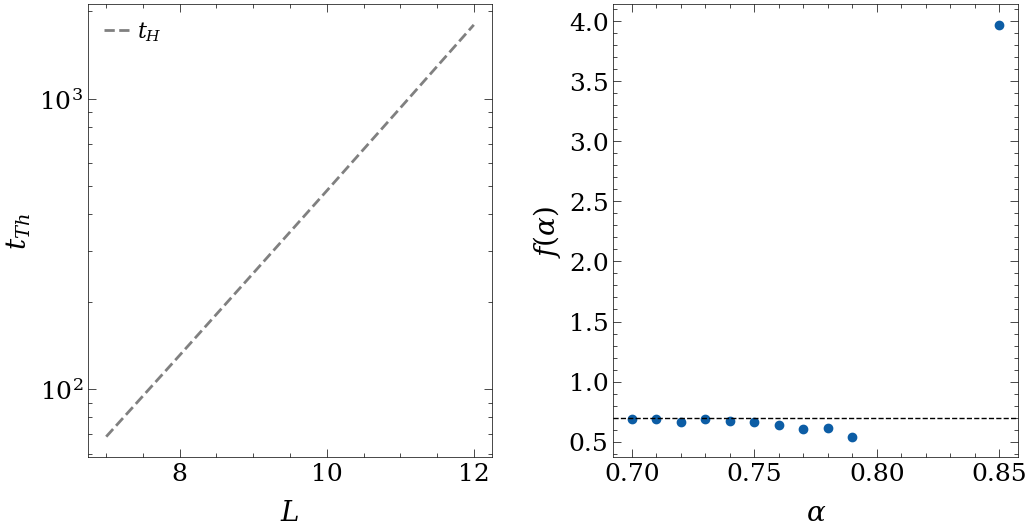

In [201]:
reload_modules()
markers = itertools.cycle(markers_ls)

label = "g_0" if user_settings['scaling_idx'] == 1 else ("\\alpha" if user_settings['scaling_idx'] == 2 else "\ ")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi = 100)
print(vals_sff)

vals = vals_sff
vals_plot = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
colors_ls_cyc = itertools.cycle(colors_ls)
exponent = []
for x in (vals):
    ijk = min(range(len(vals_sff)), key=lambda indexx: abs(vals_sff[indexx] - x))
    if np.abs(x - vals_sff[ijk]) < 0.01:
        col = next(colors_ls_cyc)
        mar = next(markers)
        tau_size = []
        sizes_found = []
        heis_time = []
        for jj, L in enumerate(sizes):
            tau = np.log10(heisenberg_time[jj][ijk] / taus[jj][ijk])
            tau = taus[jj][ijk]
            if np.isnan(tau) == False:
                tau_size.append(tau)
                sizes_found.append(L)
                heis_time.append(heisenberg_time[jj][ijk])
        
        if len(tau_size) > 2:
            tau_size = np.array(tau_size)
            sizes_found = np.array(sizes_found)

            if ijk == 0:
                axes[0].plot(sizes_found - 3, heis_time, color = 'gray', lw = 2, ls='--', label=r"$t_H$")
            
            pars, pcov = fit(f=exp_fit2, 
                            xdata=sizes_found[-4:], 
                            ydata=tau_size[-4:],
                            maxfev=100000)
            print(pars)
            exponent.append(1. / pars[0])
            if x in vals_plot:
                axes[0].plot(sizes_found - 3, tau_size, color = col, markerfacecolor = 'None', lw = 0, marker=mar, markeredgewidth=2, ls='--', label=r"$%s=%.2f$"%(label, x))
                axes[0].plot(sizes - 3, exp_fit2(sizes, *pars), color = col, lw = 1, ls='--')
        else:
            exponent.append(np.nan)
        
hfun.set_plot_elements(axis = axes[0], ylabel = "t_{Th}", xlabel = "L", settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))

axes[0].legend(loc = 'upper left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01,1.01))

axes[0].set_xscale('linear')
axes[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


axes[1].scatter((vals_sff), exponent)
hfun.set_plot_elements(axis = axes[1], ylabel = "f(%s)"%label, xlabel = label, settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))
axes[1].set_xscale('linear')
axes[1].set_yscale('linear')
axes[1].axhline(y=np.log(2), ls='--', color='black')
fig.subplots_adjust(wspace=0.3, hspace=0.02)

#plt.savefig("/Users/rafal.swietek/Desktop/QuantumSun_Results_test.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
#plt.savefig("/Users/rafal.swietek/Desktop/QuantumSun_Results_test.png", bbox_inches = 'tight', padding=0.02, transparent=False)

10
11
12
13
14
15


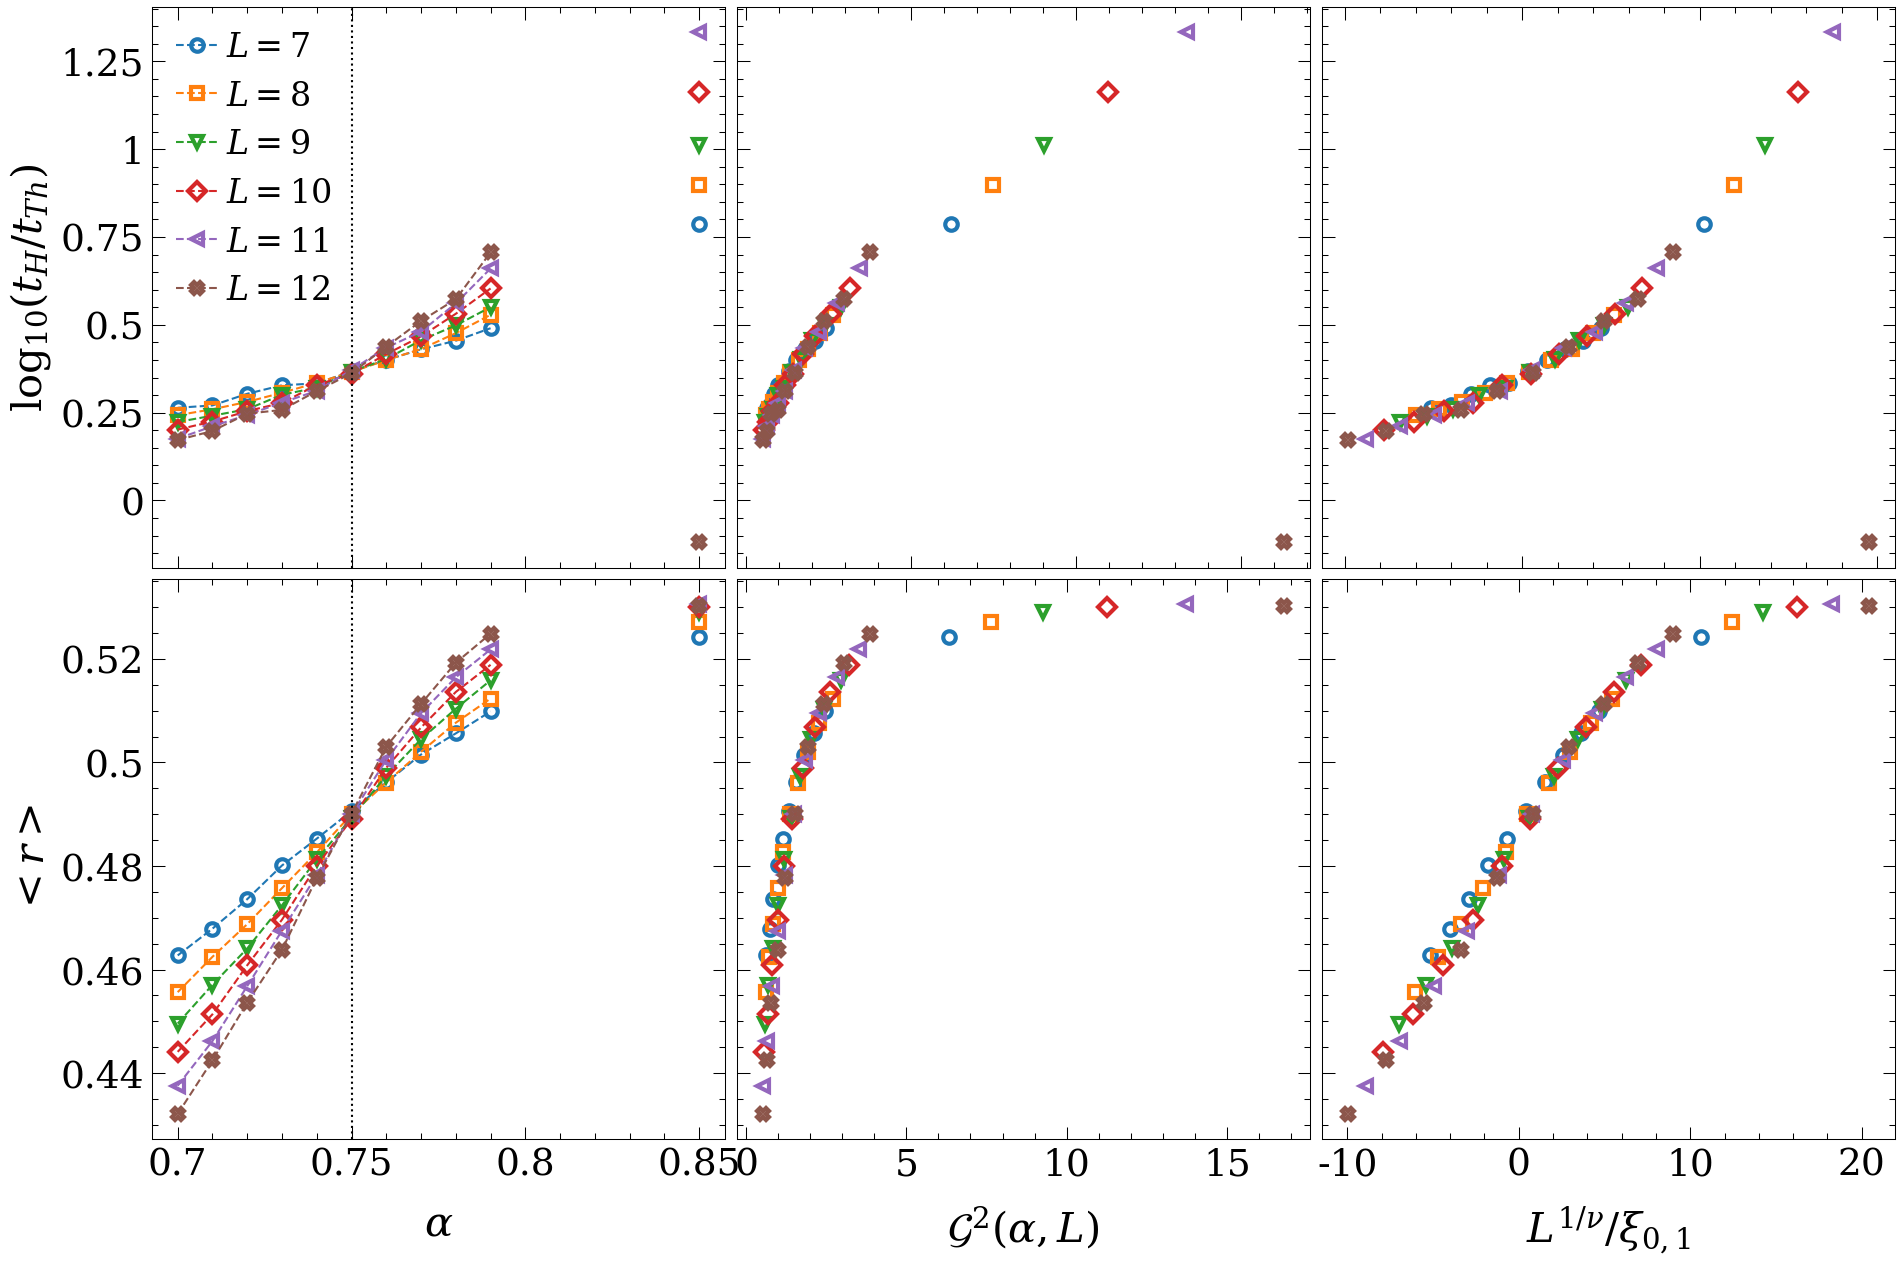

In [202]:
reload_modules()
markers = itertools.cycle(markers_ls)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi = 150)

def ksi0(alfa, alfa_c):
    return 1 / ( 2* np.log( (alfa / alfa_c) ) )

def g2(alfa, alfa_c, L):
    return ( 1 / L * ( np.exp(L / 2 / ksi0(alfa, alfa_c)) - 1 ) / ( np.exp(-1 / 2 / ksi0(alfa, alfa_c)) - 1 ) )**2

colors_ls_cyc = itertools.cycle(colors_ls)
for L in (sizes):
    jj = list(sizes).index(L)
    print(sizes[jj])
    col = next(colors_ls_cyc)

    G0 = np.log10(heisenberg_time[jj] / heisenberg_time[jj] / 1e-2)
    tau = np.log10(heisenberg_time[jj] / taus[jj])
    mar = next(markers)

    axes[0][0].plot(vals_sff,                               tau, color = col, markerfacecolor = 'None', lw = 1, marker=mar, markeredgewidth=2, ls='--', label=r"$L=%d$"%(L-3))
    axes[0][1].plot(g2(vals_sff, 0.732, L),                 tau, color = col, markerfacecolor = 'None', lw = 0, marker=mar, markeredgewidth=2)
    axes[0][2].plot(L**(1 / 0.626) / ksi0(vals_sff, 0.747), tau, color = col, markerfacecolor = 'None', lw = 0, marker=mar, markeredgewidth=2)

    axes[1][0].plot(vals_sff,                               gap_ratio[jj], color = col, markerfacecolor = 'None', lw = 1, label=r"$L=%d$"%L, marker=mar, markeredgewidth=2, ls='--')
    axes[1][1].plot(g2(vals_sff, 0.731, L),                 gap_ratio[jj], color = col, markerfacecolor = 'None', lw = 0, label=r"$L=%d$"%L, marker=mar, markeredgewidth=2)
    axes[1][2].plot(L**(1 / 0.621) / ksi0(vals_sff, 0.746), gap_ratio[jj], color = col, markerfacecolor = 'None', lw = 0, label=r"$L=%d$"%L, marker=mar, markeredgewidth=2)
    #axis.scatter(vals_sff, heisenberg_time[jj], marker='s', color = col, s=10)

hfun.set_plot_elements(axis = axes[0][0], ylabel = "\log_{10}(t_H/t_{Th})", xlabel = "\ ", settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axes[0][1], ylabel = "\ ", xlabel = "\ ", settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axes[0][2], ylabel = "\ ", xlabel = "\ ", settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))

hfun.set_plot_elements(axis = axes[1][0], ylabel = "<r>", xlabel = label, settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axes[1][1], ylabel = "\ ", xlabel = "\\mathcal{G}^2(%s,L)"%label, settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))
hfun.set_plot_elements(axis = axes[1][2], ylabel = "\ ", xlabel = "L^{1/\\nu}/\\xi_{0,1}", settings=user_settings, 
                        font_size=18, set_legend=False, xlim=(None, None), ylim=(None, None))

axes[0][0].legend(loc = 'upper left', frameon=False, fontsize=16, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01,1.01))

#axis.set_ylim(1e1, 3e4)
for axol in axes:
    for ax in axol:
        ax.set_xscale('linear')
        ax.set_yscale('linear')

for ax in [axes[0][0], axes[1][0]]:
    #ax.set_xlim(0.69, 0.8)
    ax.axvline(x=0.75, ls=':', color='black')

axes[0][0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axes[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axes[0][2].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

axes[1][0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axes[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axes[1][2].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

axes[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axes[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axes[0][2].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axes[1][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axes[1][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axes[1][2].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))



fig.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig("/Users/rafal.swietek/Desktop/QuantumSun_Results_test.pdf", bbox_inches = 'tight', padding=0.02, transparent=False)
plt.savefig("/Users/rafal.swietek/Desktop/QuantumSun_Results_test.png", bbox_inches = 'tight', padding=0.02, transparent=False)

[12 14 16 18]
[12 14 16 18]


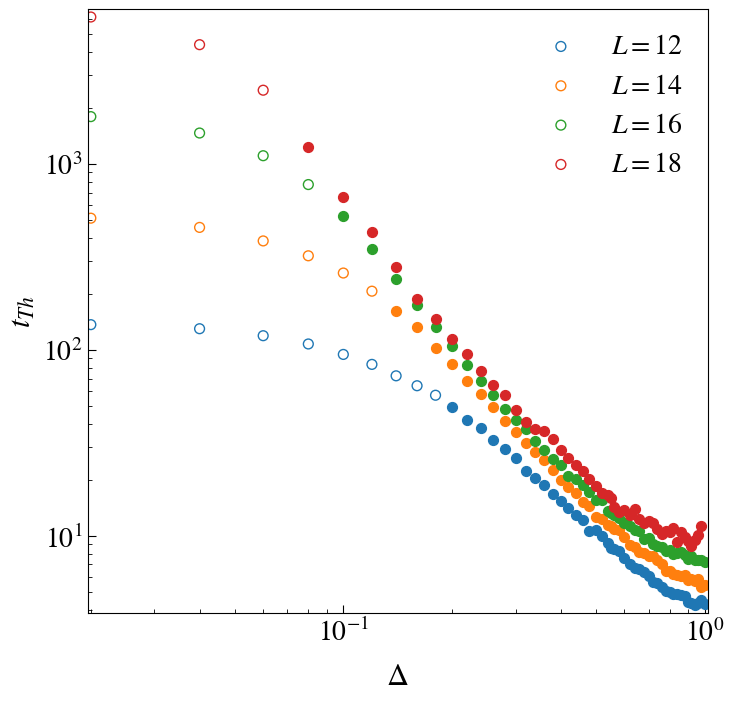

In [53]:
reload_modules()

new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs('g')
new_set_class.set_scaling('L')
settings = getattr(new_set_class, 'settings')

vals = np.arange(12, 19, 2)
fig, axis = plt.subplots(nrows=1,ncols=1,figsize=(8,8), dpi = 100)
vals, xvals, tau, gap_ratio, c = thouless.plot_taus(axis=axis, settings = settings, vals=vals, fontsize=20, linewidth=0., return_data=True, markersize=50)
#print(tau)

../results/QUANTUM_SUN/disorder/SpectralFormFactor/_L=0,J=1.00,J0=0.20,g=0.75,g0=0.00,h=1.00,w=0.50.dat [0.0, 1.0, 0.75, 1.0, 0.5, 0, 1, 1, 0.0, 0.0]
1 [0.7]


ValueError: min() arg is an empty sequence

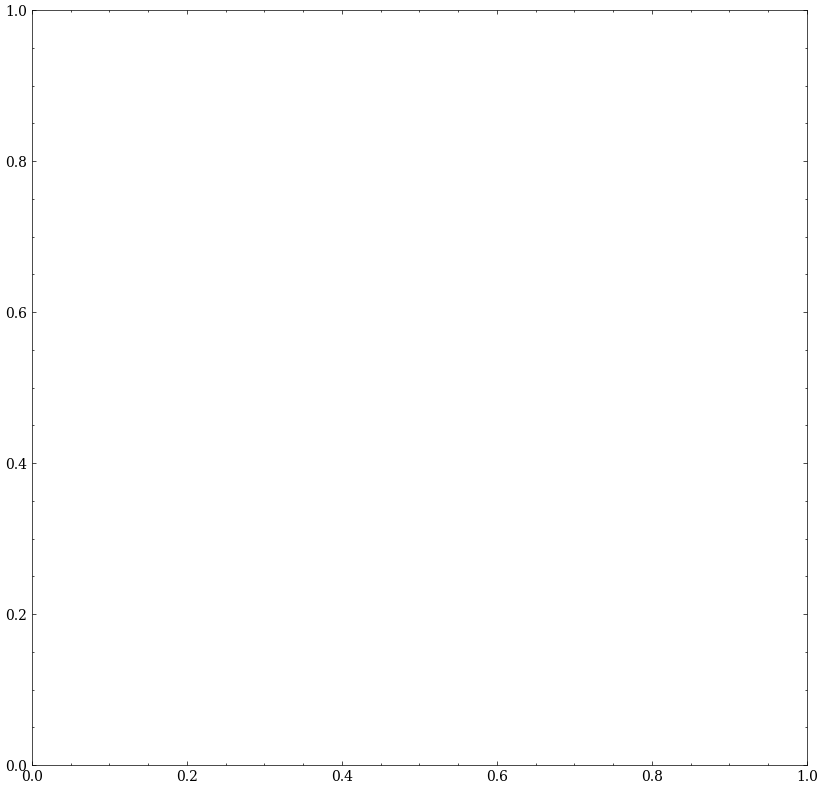

In [204]:
reload_modules()
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)
vals_sff = [0.7]
  
plot_deviation = 0

if plot_deviation:
    sff_module.plot_deviation(axis=axis, vals=vals_sff)
else:
    #axis.grid(b=True, which='major', color='0.65', linestyle='-')
    #axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    
    #width = 0.4
    #height= 0.4
    #left, bottom, width, height = [1 - width, 1 - height, width, height]
    #axis2 = hfun.add_subplot_axes(axis, [left, bottom, width, height])
    for beta in hfun.regspace(0.0, 2.0, 0.2):
        sff_module.plot(axis=axis, vals=vals_sff, axis_inset=None, zoom = False, folded = False, beta=beta)
    axis.set_ylim(1e-3, 3e2)
    axis.set_xlim(5e-4, 10)

# PLOT SPECTRAL FUNCTIONS

### PREAMBLE

In [ ]:
# SET LEGEND FUNCTION

from matplotlib.lines import Line2D
def add_legend(axis):
    legend = axis.legend()
    #ax = legend.axes

    handles, labels = axis.get_legend_handles_labels()
    if user_settings['scaling'] == 'k':
        new_lab = []
        for label in labels:
            label = list(label)
            label[1] = 'q'
            new_lab.append("".join(label))
        labels = new_lab
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black'));   labels.append(r"$\omega_H$")
    handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='o', color='black', markerfacecolor='None'));   labels.append(r"$\omega^{typ}_H$")
    #handles.append(Line2D([0], [0], linewidth=1, linestyle='--', marker='s', color='black'));   labels.append(r"$\omega_{Th}$")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
    axis.legend(handles, labels, frameon=False, loc='best', fontsize=10)




use_derivative = 0
time_dir = cf.base_directory + "timeEvolution%s"%kPSep
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep)

## MAIN SPECTRALS

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
../results/HEISENBERG/disorder/PBC/timeEvolution/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10.dat
../results/HEISENBERG/disorder/PBC/timeEvolution/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.30.dat
../results/HEISENBERG/disorder/PBC/timeEvolution/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.50.dat
../results/HEISENBERG/disorder/PBC/timeEvolution/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.70.dat
../results/HEISENBERG/disorder/PBC/timeEvolution/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.90.dat
../results/HEISENBERG/disorder/PBC/IntegratedResponseFunction/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.10.dat
../results/HEISENBERG/disorder/PBC/IntegratedResponseFunction/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.30.dat
../results/HEISENBERG/disorder/PBC/IntegratedResponseFunction/j=9/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.0

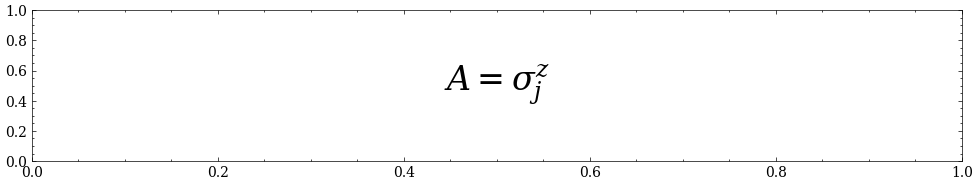

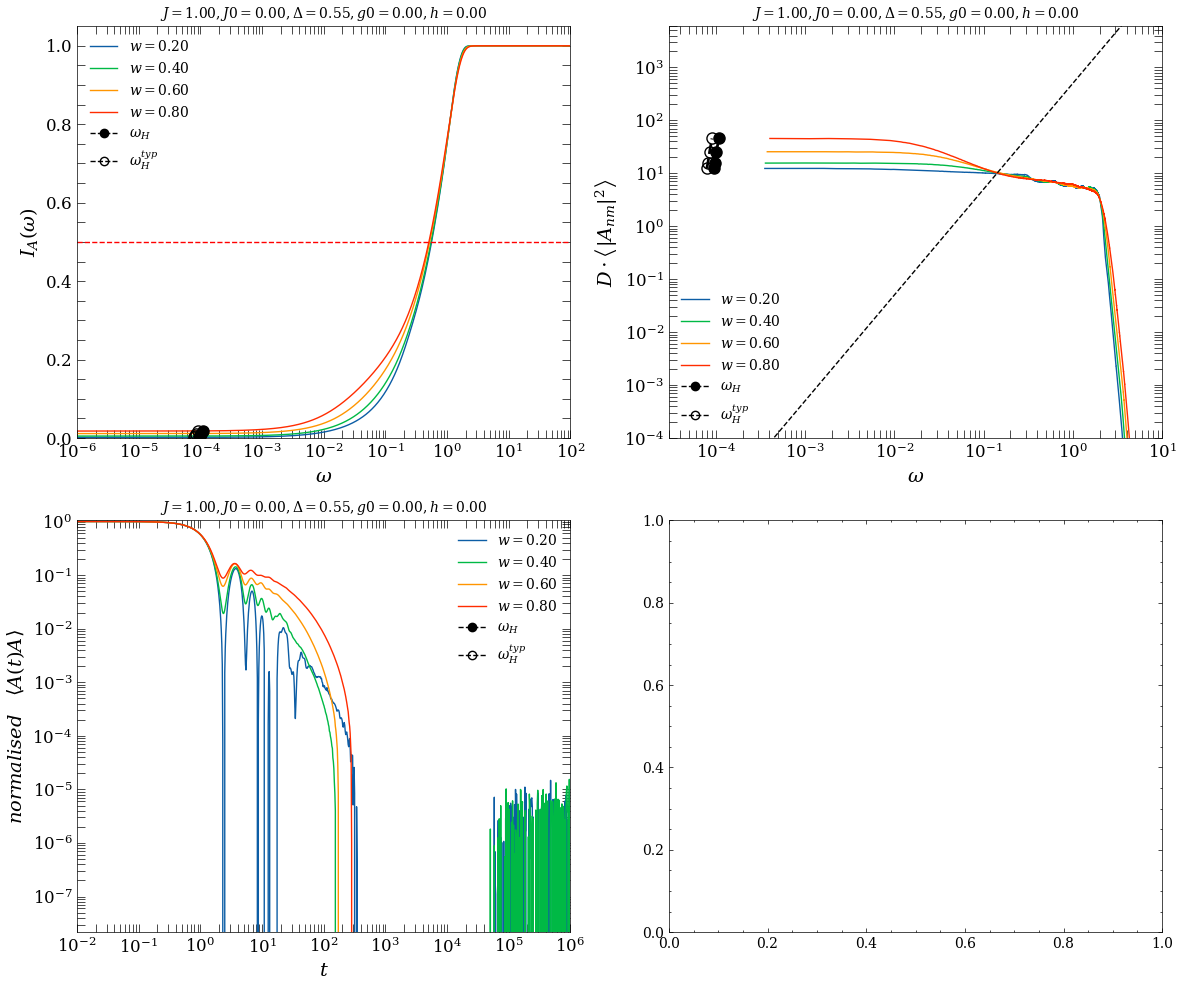

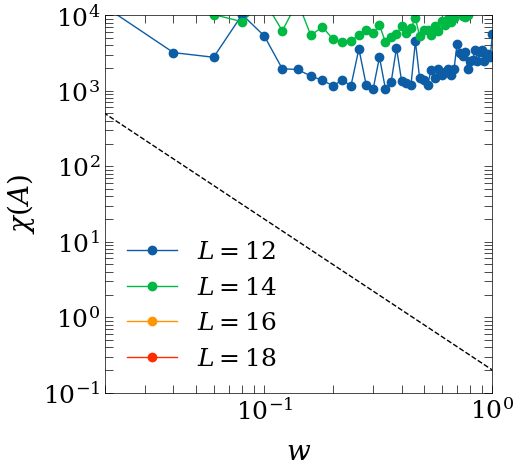

In [77]:

reload_modules()
x0 = 0.1
xend = 0.9
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)
print(vals)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,2), dpi = 100)
axis.annotate(r"$A=$"+cf.operator_formuals[user_settings['operator']], xy=(0.5, 0.5), color='black', size=24, ha='center', va='center')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(14,12), dpi = 100)
alfa = 0.0
func_t = lambda y, x: y / x**alfa
func_w = lambda y, x: y.astype(float) * x**alfa

#---------------------- TIME EVOLUTION
spec_fun.plot_spectral(axis = ax3, settings=user_settings, vals = vals,
                        xlab="t", ylab="\\langle A(t)A\\rangle", 
                        xscale='log',yscale='log', normalise=True, 
                        spec="time", func_x=func_t, smoothed=False)
add_legend(axis=ax3)
#ax3.set_ylim(-0.01,0.05)
#ax3.set_xlim(1e0,1e4)

#---------------------- INTEGRATED SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax1, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="I_A(\\omega)", 
                        yscale='linear', normalise=False, 
                        spec="int", func_x=func_w)
add_legend(axis=ax1)
ax1.axhline(y=0.5, ls='--', color='red')
#ax1.legend(title=r"$A=H_{q=1}$")
ax1.set_ylim(0,1.05)
#ax1.set_xlim(1e-3, 2e1 * 18**alfa)

#---------------------- SPECTRAL FUNCTION
spec_fun.plot_spectral(axis = ax2, settings=user_settings, vals = vals,
                        xlab="\\omega", ylab="D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", 
                        xscale='log', yscale='log', func_x=func_w, 
                        spec="spec", use_derivative=use_derivative, smoothed=False)
if use_derivative: ax2.set_ylim(5e-30, 1e3)
else: ax2.set_ylim(1e-4, 6e3)
ax2.set_xlim(3e-5, 1e1)
add_legend(axis=ax2)
xval=np.logspace(-6,1,100)
#ax2.plot(xval, 0.38+2*xval, linestyle='--', color='black')
ax2.plot(xval, (5e2 * xval**2), linestyle='--', color='black')
#ax2.plot(xval, 3e0/xval**2, linestyle='--', color='red')



figo, ax_agp = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 100)
ax4 = ax_agp
#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs("w")
new_set_class.set_scaling("L")
new_set_class._settings['site'] = -1
new_set_class.set_scales(xscale='log', yscale='log')
sizes = np.arange(12, 19, 2)
agp.plot_agp(axis = ax4, settings_class=new_set_class, which=3, operator=user_settings['operator'], site=-1, vals = sizes)
ax4.set_ylim(1e-1, 1e4)
ax4.plot(xval, 0.2/xval**2, ls='--', color='black')


(1e-05, 1)

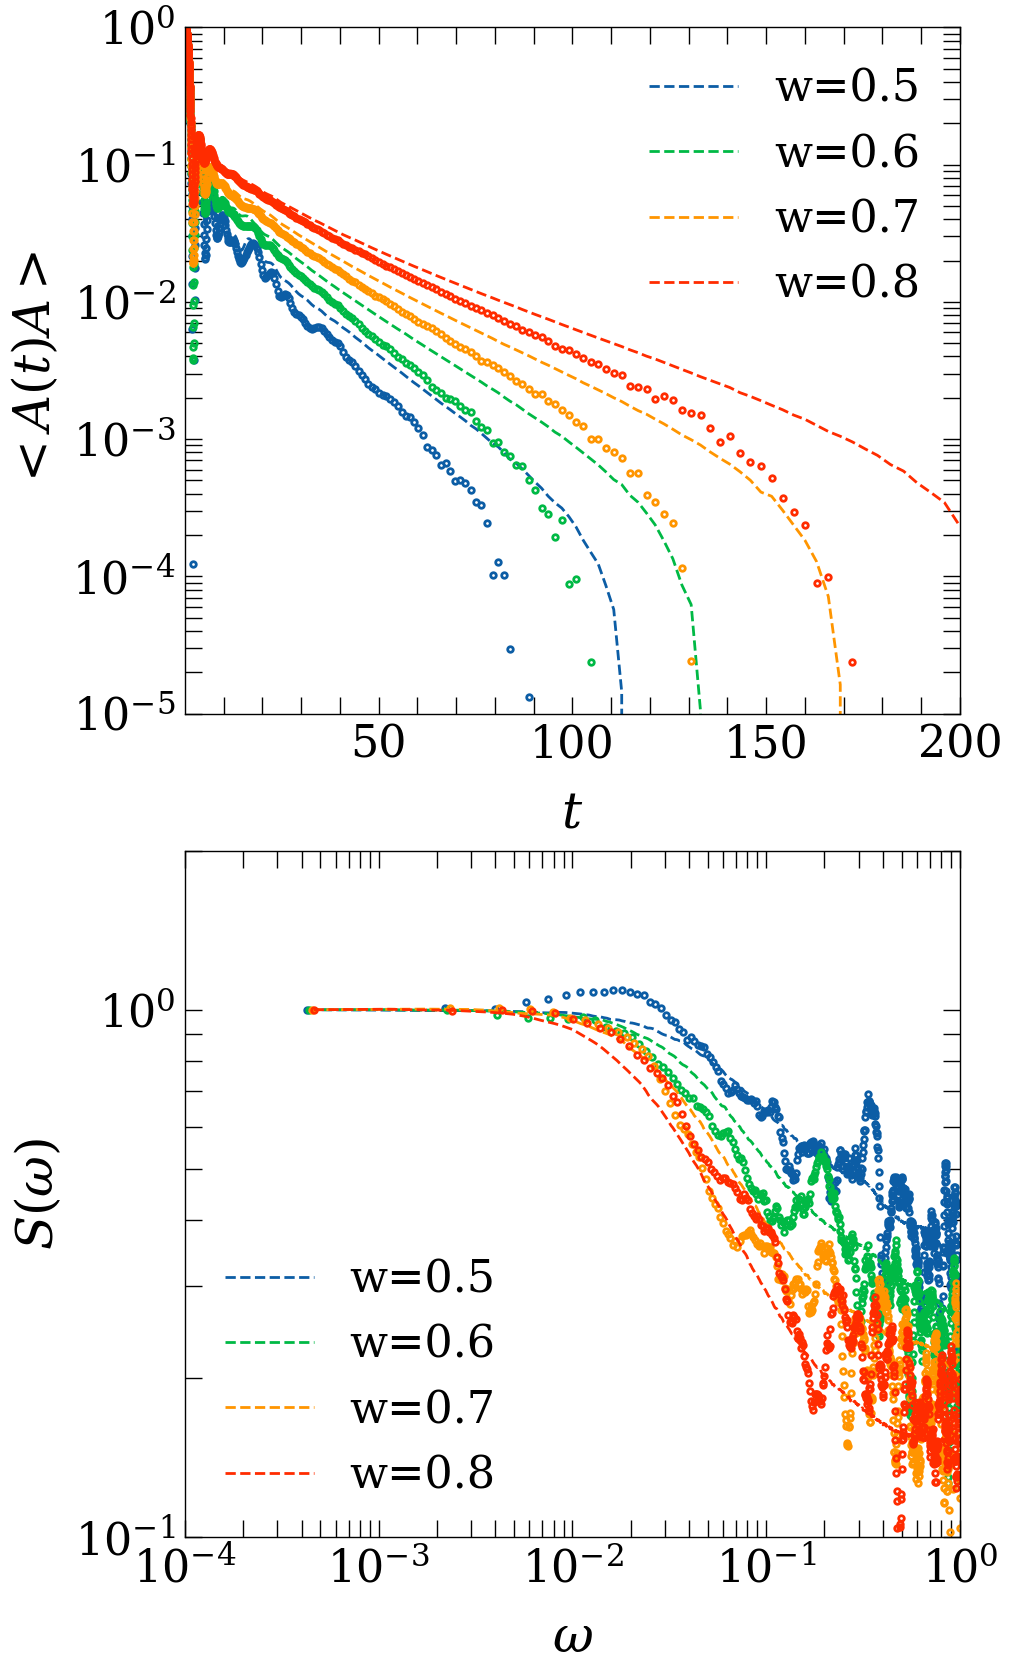

In [162]:
reload_modules()
user_settings = getattr(cf.plot_settings, 'settings')

fig, axes = plt.subplots( nrows=2, ncols=1, figsize=(5,10), dpi = 200)
axis = axes[0]

x0 = 0.5
xend = 0.8
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)
#vals = [0.6]


axes[1].set_ylim(1e0, 1e2)

for x in vals:
    status1, times, autocorrelation, wHnow, wHtypnow = spec_fun.load_spectral(settings=user_settings, 
                                                                parameter=x,
                                                                spec="time",
                                                                smoothed=False,
                                                                normalise=True
                                                                )

    status2, omegas, spectral_fun, wHnow, wHtypnow = spec_fun.load_spectral(settings=user_settings, 
                                                                parameter=x,
                                                                spec="spec",
                                                                smoothed=True
                                                                #,normalise=True
                                                                )   
    if status1 and status2:
        auto_fft = []
        for Tt in times:
            expons = np.exp( -1j * omegas * Tt )
            auto_fft.append( integrate.simpson( expons * spectral_fun, omegas ) )
        auto_fft = np.array(auto_fft)
        p = axis.plot(times, autocorrelation, ls = '--', label=r"w=%.1f"%x)
        axis.plot(times, auto_fft / auto_fft[0], lw = 0, marker = 'o', color = p[0].get_color(), markerfacecolor='None', markersize=2)


        spec_fun_fft = []
        omega_new = omegas[::3]
        for ome in omega_new:
            expons = np.exp( 1j * ome * times )
            spec_fun_fft.append( integrate.simpson( expons * autocorrelation, times ) )
        window = 91
        spec_fun_fft = savgol_filter(np.array(spec_fun_fft), window_length= window + window % 2 - 1, polyorder=7, mode="mirror")
        p = axes[1].plot(omegas, spectral_fun / spectral_fun[0], ls = '--', label=r"w=%.1f"%x)
        axes[1].plot(omega_new, spec_fun_fft / spec_fun_fft[0], lw = 0, marker = 'o', color = p[0].get_color(), markerfacecolor='None', markersize=2)


hfun.set_plot_elements(axis = axis, xlim = (1e-2, 2e2), 
                                    ylim = (1e-6, None), ylabel = "<A(t)A>", xlabel = "t", settings=settings, font_size=16, set_legend=True)


hfun.set_plot_elements(axis = axes[1], xlim = (1e-4, 1e0), 
                                    ylim = (1e-1, 2), ylabel = "S(\\omega)", xlabel = "\\omega", settings=settings, font_size=16, set_legend=True)
axis.set_xscale('linear')
axis.set_ylim(1e-5, 1)

## SPECTRAL FUNCTION WITH RELAXATION TIME

In [ ]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,10), dpi = 100)

func = lambda y, x: y #* x**1.33

vals_spec = hfun.get_scaling_array(user_settings, 0.2, 1.8, 0.2)

spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals_spec, 
                        xlab="\\omega", ylab="S_A(\\omega)", yscale='log', xscale='log', 
                        normalise=False, spec="spec", func_x=func, 
                        use_derivative=use_derivative, smoothed=False)
add_legend(axis=axis)
addition = r"$\quad j=\frac{L}{2}$" if user_settings['operator'] < 8 else ""
try:
    idx = (cf.operator_formuals[user_settings['operator']][2:]).index("=")
    leg = axis.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']][0:idx] + "$" + addition, loc='upper right')
except ValueError:
    leg = axis.legend(title=r"$A=$"+cf.operator_formuals[user_settings['operator']] + addition, loc='upper right')

axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')
axis.set_ylim(1e-3, 2e2)
axis.set_xlim(6e-5, 9e0)
#leg = axis.legend(title=r"$A=J^s_{cur}$", fontsize=18, loc='lower right')
#leg.get_title().set_fontsize('18')
#axis.title.set_text("")

ii = user_settings['scaling_idx']
xlab = "q/\\pi" if ii == 5 else (hfun.var_name if ii == 2 else user_settings['scaling'])

left, bottom, width, height = [0.2, 0.17, 0.3, 0.3]
axis2 = fig.add_axes([left, bottom, width, height])
vals = hfun.get_scaling_array(settings=user_settings, 
                                    x0=0.02, 
                                    xend=1.02, 
                                    dx=0.02)

status_time, taus, relax_time, relax_time_fit, tH, tH_typ, gap_ratio = spec_fun.get_relax_times(vals=vals, with_thouless=True)
print(relax_time, relax_time_fit)
trueQ = 2 * vals / cf.L if user_settings['scaling_idx'] == 5 else vals    
spec_fun.set_inset(axis2, user_settings, trueQ, taus, relax_time, relax_time_fit, tH, tH_typ, status_time)
axis2.set_ylim(1e-1,1e5)

#fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2, figsize=(14,8), dpi = 100)
#spec_fun.set_inset(ax1, user_settings, vals, taus, relax_time, relaxt_time_fit, tH, tH_typ, status_time)
#ax2.plot(trueQ, relaxt_time_fit / taus, marker='o')
#ax2.plot(trueQ, 11. * (1.0 - 0.03 / trueQ)**2, linestyle='--', label=r"$\left( 1 - \frac{%s_c}{%s}\right)^2$"%(xlab, xlab))
#spec_fun.set_inset_style(axis = ax2, 
#                vals = vals, 
#                settings = user_settings,
#                ylim = (2, 15),
#                ylabel = "\\tau_{rel}/\\tau_{Th}")
#ax2.set_xscale('linear')
#ax2.set_yscale('linear')

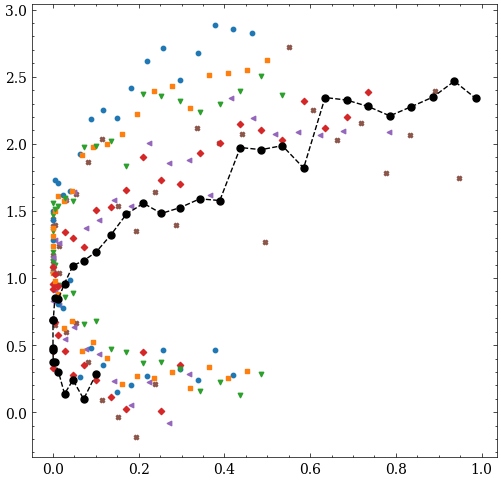

In [75]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 100)

new_set_class.set_vs("L")
new_set_class.set_scaling("w")
new_set_class._settings['site'] = -1
new_set_class.set_scales(xscale='log', yscale='log')
vals_th = hfun.get_scaling_array(user_settings, 0.3, 1.0, 0.02)

def xi_kbt(Wx, W_crit):
    return np.exp(2 / np.sqrt(np.abs( Wx - W_crit)))

alfa = []
w_crit_size = [0.64, 0.56, 0.52, 0.46]
for wx in vals_th:
    status_time, xvalues, taus, gap_ratio = spec_fun.get_thouless_time(par = wx, set_class=new_set_class, scaling_vals=vals_th)
    if xvalues[0] < 12:
        xvalues =  xvalues[1:]
        taus    =  taus[1:]
    
    exponent = 0
    counter = 0
    markers = itertools.cycle(markers_ls)
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, Li in enumerate(xvalues):
        for jj, Lj in enumerate(xvalues):
            if jj > ii:
                val = np.log(taus[jj] / taus[ii]) / np.log(Lj / Li)
                mean_L = (Li + Lj) / 2
                axis.scatter(mean_L / xi_kbt(wx, w_crit_size[ int(Li-12) // 2]), val, c=next(colors_ls_cyc), marker=next(markers), s=10)
                exponent += val
                counter += 1
    alfa.append(exponent / counter)


axis.plot(15 / xi_kbt(vals_th, w_crit_size[-1]), alfa, c='black', ls='--', marker='o', markersize=5)

## SHOW FIT AND RELAX TIME PLOT

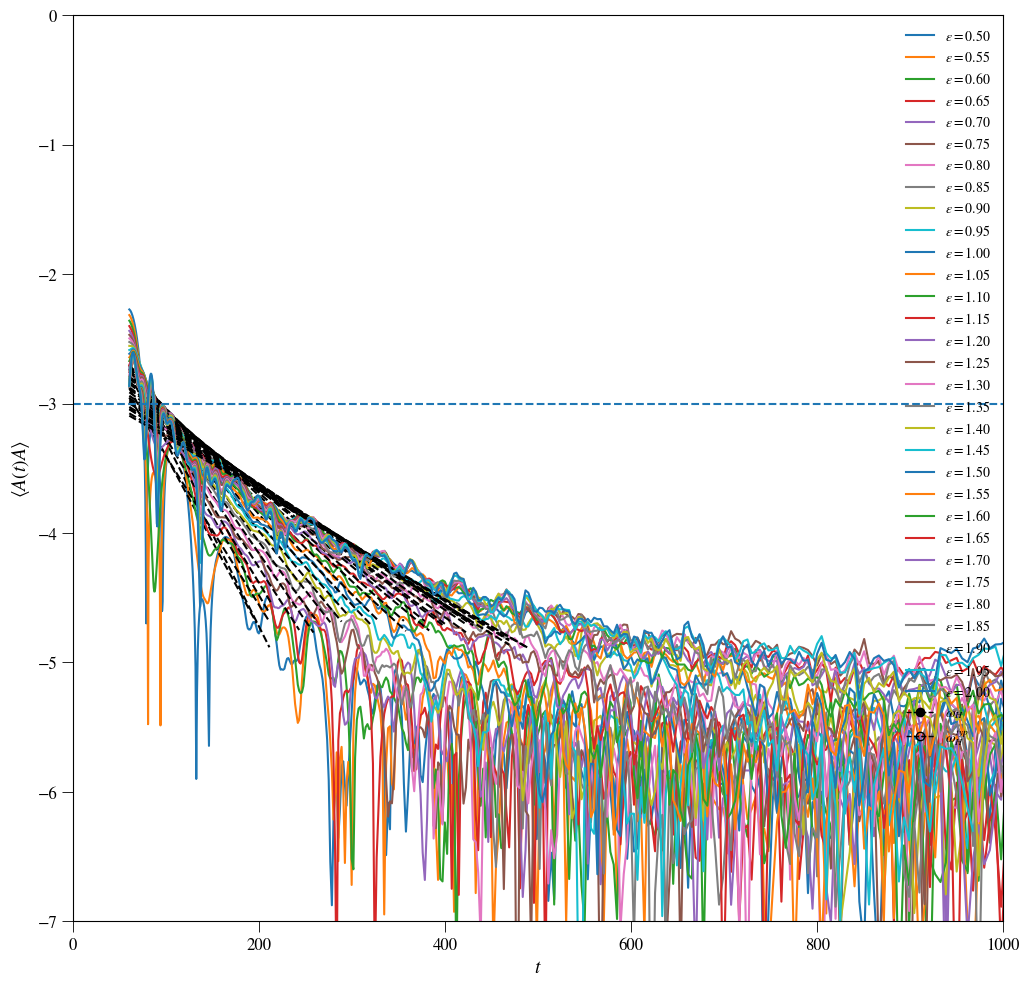

In [ ]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(12,12), dpi = 100)

func = lambda y, x: y# * x**1.33

xxx = 0.02

vals = hfun.get_scaling_array(settings=user_settings, 
                                    x0=0.5, 
                                    xend=2.0, 
                                    dx=0.05)
#---------------------- TIME EVOLUTION
#spec_fun.plot_spectral(axis = axis, settings=user_settings, vals = vals,
#                        xlab="t", ylab="\\langle A(t)A\\rangle", 
#                        yscale='linear', normalise=True, 
#                        spec="time", func_x=func)


relaxt_time_fit = []
relaxt_time_approx = []
tH = []
tH_typ = []
for i in range(0, len(vals)):
    x = vals[i]
    status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="time",
                                                                    normalise=True, smoothed=True
                                                                    )
    if status:
        idx = xover_from_above(ydata, 1e-3)
        relaxt_time_approx.append(xdata[idx])
        xfull = xdata
        ydata = np.log10(np.abs(ydata))
        cut = 60
        if x <= 0.15: cut = 200
        xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (xdata[i] < 4000 and xdata[i] > cut)])
        ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (xfull[i] < 4000 and xfull[i] > cut)])
        
        axis.plot(xdata, ydata, label=hfun.key_title(x, user_settings))
        idx_zero = np.argmin((ydata))
        ydata = ydata[:idx_zero - 8]
        xdata = xdata[:idx_zero - 8]
        xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (ydata[i] > -4.5)])
        ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (ydata[i] > -4.5)])
        #

        #idx = np.where(ydata == np.amin(ydata))
        #print(idx)
        #xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (ydata[i] < (-0.6 if x > 0.2 else -0.6))])
        #ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (ydata[i] < (-0.6 if x > 0.2 else -0.6))])
        #print(pars2
        tH.append(wHnow)
        tH_typ.append(wHtypnow)
        #continue;
        pars, pcov = fit(f=lin_fit, 
                            xdata=xdata, 
                            ydata=ydata)
        
        if any((np.diag(pcov)) / pars > 5):
            relaxt_time_fit.append(nan)
        else:
            relaxt_time_fit.append(pars[0])
            axis.plot(xdata, lin_fit(xdata, *pars), linestyle='--', color='black')
    else:
        tH.append(nan)
        tH_typ.append(nan)
        relaxt_time_fit.append(nan)
        relaxt_time_approx.append(nan)

#
hfun.set_plot_elements(axis = axis, xlim = (None, None), 
                                    ylim = (None, None), ylabel = "\\langle A(t)A\\rangle", xlabel = "t", settings=user_settings, font_size=12, set_legend=True)
  
axis.set_xscale('linear')
axis.set_yscale('linear')
axis.axhline(y=-3, linestyle='--')
axis.set_xlim(0,1e3)
axis.set_ylim(-7,0)
add_legend(axis=axis)
#relaxt_time_fit = 1.0 / np.array(relaxt_time_fit)
tH = np.array(tH)
tH_typ = np.array(tH_typ)

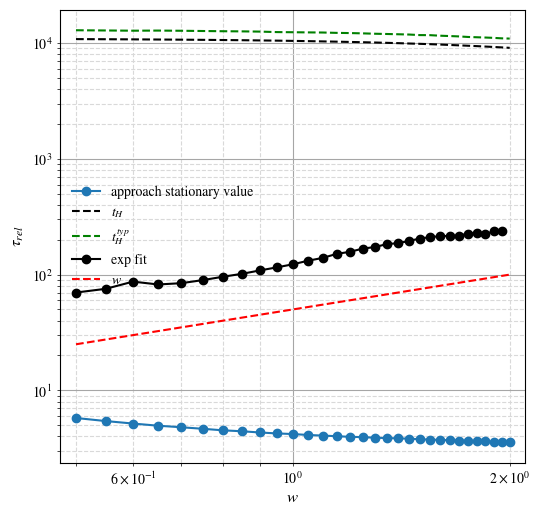

In [ ]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 100)

xlab = "q/\\pi" if user_settings['scaling_idx'] == 5 else user_settings['scaling']

xrescale = lambda x: x
axis.plot(xrescale(vals), relaxt_time_approx, marker='o', label = 'approach stationary value')

axis.plot(xrescale(vals), tH, linestyle='--', color = 'black', label = r"$t_H$")
axis.plot(xrescale(vals), tH_typ, linestyle='--', color = 'green', label = r"$t_H^{typ}$")
axis.plot(xrescale(vals), relaxt_time_fit, marker='o', color = 'black', label = 'exp fit')

axis.plot(xrescale(vals), 5e1*vals**1, linestyle='--', color='red', label=r"$w$")

#if status and user_settings['scaling_idx'] == 5: 
#    axis.axhline(y=taus[0], ls='--', color='black')
#    axis.annotate("$\it{Thouless}\ \it{Time}$", xy=(0.3,1.5e3), color='black', size=12)
#else: 
#    if status == False or cf.model == 2: print('No data')
#    else: axis.plot(vals, taus, linestyle='--', color='black', label=r"$\tau_{Th}$")

hfun.set_plot_elements(axis = axis, xlim = (0.95*min(xrescale(vals)), 1.05*max(xrescale(vals))), 
                                    ylim = (None, None),ylabel = "\\tau_{rel}", xlabel = xlab, settings=user_settings, font_size=10, set_legend=True)
  
axis.set_yscale('log')
axis.set_xscale('log')
axis.tick_params(axis='both', which='both',length=2)
axis.grid(b=True, which='major', color='0.65', linestyle='-')
axis.grid(b=True, which='minor', color='0.85', linestyle='--')


## COMPARE FUNCTIONS

### LONG $\omega$ tail

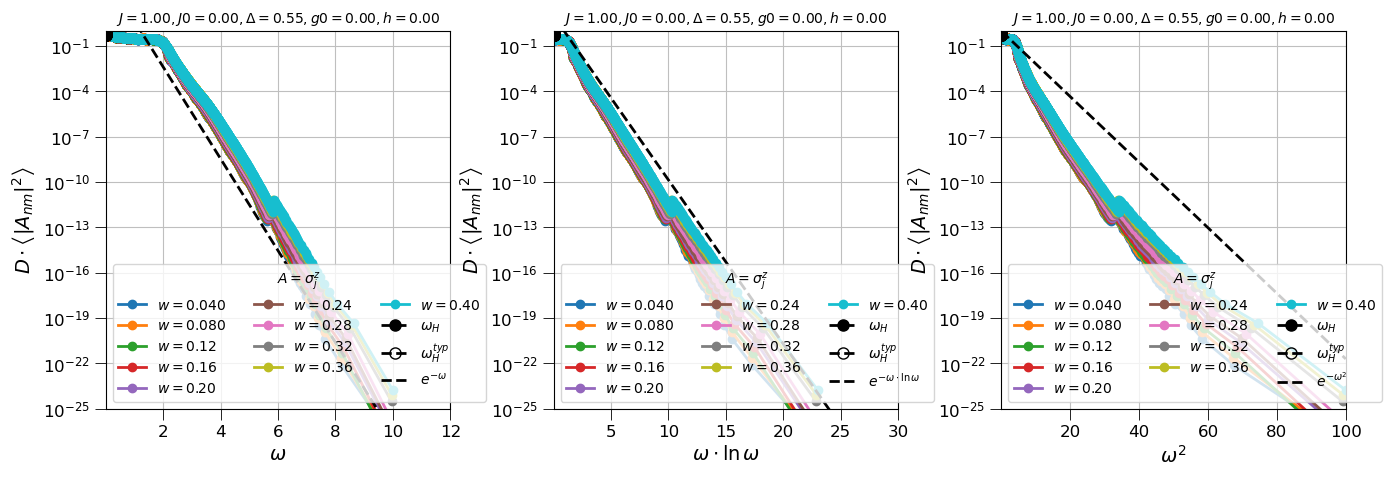

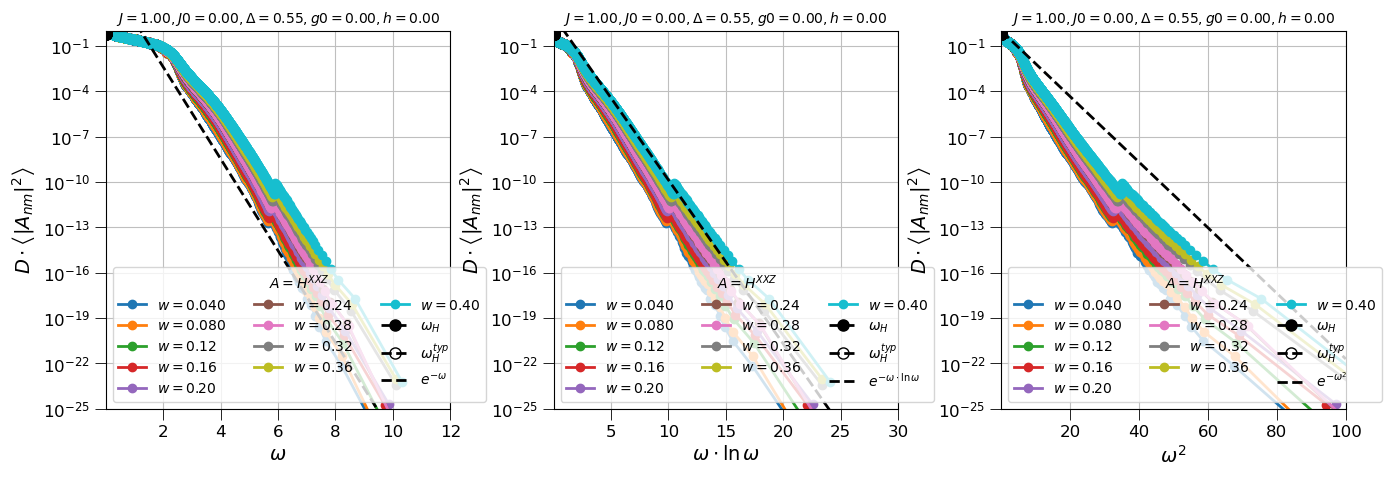

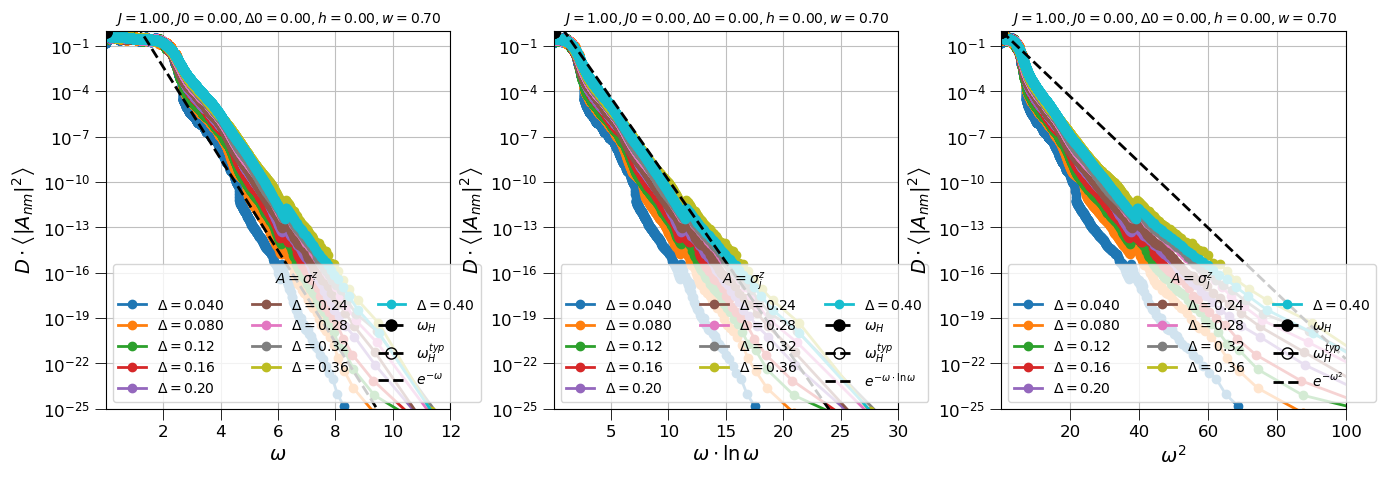

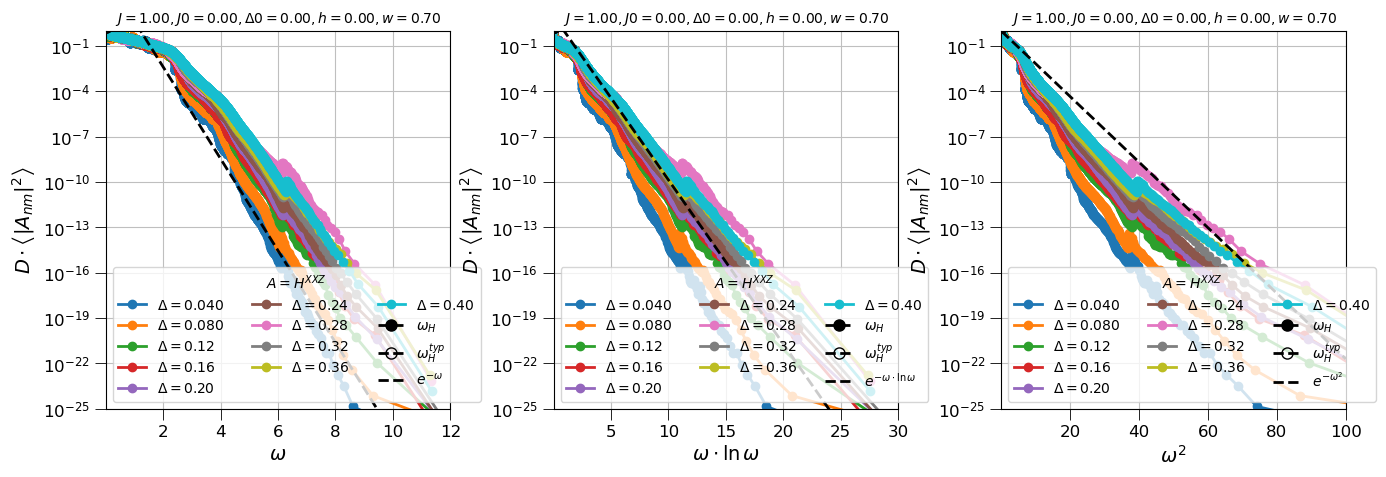

In [ ]:
reload_modules()
def temporary_plot_spec_tail(operatorr, settings):
    fig, axes = plt.subplots( nrows=1, ncols=3, figsize=(16,5), dpi = 100)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    wH = [];    LTA = []
    wH_typ = [];    val_at_typ = [];
    omegas = np.logspace(-5, 0, 1000)
    funcs = [lambda x: x, lambda x: x * np.log(x), lambda x: x**2]
    funclabels = ["\\omega", "\\omega\\cdot\\ln\\omega", "\\omega^2"]
    
    for i, func_tail in enumerate(funcs):
        axis = axes[i]
        for x in vals:                    
            status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                            settings=settings, 
                                                            parameter=x,
                                                            spec="spec",
                                                            func_x=lambda x, a: x,
                                                            operator = operatorr,
                                                            site = cf.L/2
                                                            )
            if status:
                ydata = ydata * (2**x / x if settings['scaling_idx'] == 0 else 2**cf.L / cf.L) # rescale by D                                                    
                if wHnow is None or np.isnan(wHnow):
                        wHnow = 1e-5
                        wHtypnow = 1e-6
                p = axis.plot(func_tail(xdata), ydata,label=hfun.key_title(x, settings), linewidth=2, markersize=6, marker='o')
                "mean";     wH.append(wHnow);           idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHnow));     LTA.append(ydata[idx])
                "typical";  wH_typ.append(wHtypnow);    idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHtypnow));  val_at_typ.append(ydata[idx])

        #axis.plot(omegas, 0.4 / (omegas)**0.5, linestyle='--', color='red', label=r"$\omega^{-0.5}$") 
        #axis.plot(omegas, 0.1 / (omegas)**0.75, linestyle='--', color='black', label=r"$\omega^{-0.75}$")        
        hfun.set_plot_elements(axis = axis, ylabel = "D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", xlabel = funclabels[i], settings=settings, font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
        axis.set_xscale('linear')
        axis.set_yscale('log')
        x_min = 0.5 * np.min(wH_typ)
        axis.set_xlim(x_min, [12, 30, 100][i])
        axis.set_ylim(1e-25, 1e0)
        axis.grid(b=True, which='major', color='0.75', linestyle='-')
        axis.grid(b=True, which='minor', color='0.85', linestyle='--')
        #add_legend(axis=axis)

        axis.plot(wH, LTA, linestyle='--', marker='o', color='black', linewidth=2, markersize=8, label=r"$\omega_H$")
        axis.plot(wH_typ, val_at_typ, linestyle='--', marker='o', color='black', markerfacecolor='None', linewidth=2, markersize=8, label=r"$\omega_H^{typ}$")
        xxxx = np.linspace(0,100,100)
        a = [7, 2.5, 0.5]
        amp = [5e3, 1e1, 1e0]
        axis.plot(xxxx, amp[i] * np.exp(-a[i] * (xxxx)), linestyle='--', color='black', linewidth=2, label=r"$e^{-%s}$"%funclabels[i])
        try:
            idx = (cf.operator_formuals[operatorr][2:]).index("=")
            leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr][0:idx] + "$", loc='lower left', ncol=3)
        except ValueError:
            leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr], loc='lower left', ncol=3)

        title = ""
        if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
            title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
        else :
            title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
        if settings['vs_idx'] != 2 :
            try : 
                title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            except ValueError:
                    print("not found")
        axis.title.set_text(r"$%s$"%title[1:])
        axis.title.set_fontsize(10)

cf.set_params(_g=0.55)
temporary_plot_spec_tail(operatorr=0, settings=user_settings)
temporary_plot_spec_tail(operatorr=2, settings=user_settings)

cf.set_params(_w=0.7)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scaling("g")
settings = getattr(new_set_class, 'settings')
temporary_plot_spec_tail(operatorr=0, settings=settings)
temporary_plot_spec_tail(operatorr=2, settings=settings)

### 4x panel

../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.12.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.20.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.36.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.44.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/SigmaZ_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.72.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/H_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.12.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/H_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h=0.00,w=0.20.dat
../results/HEISENBERG/disorder/PBC/ResponseFunction/j=9/smoothed/H_j=9_L=18,J=1.00,J0=0.00,g=0.55,g0=0.00,h

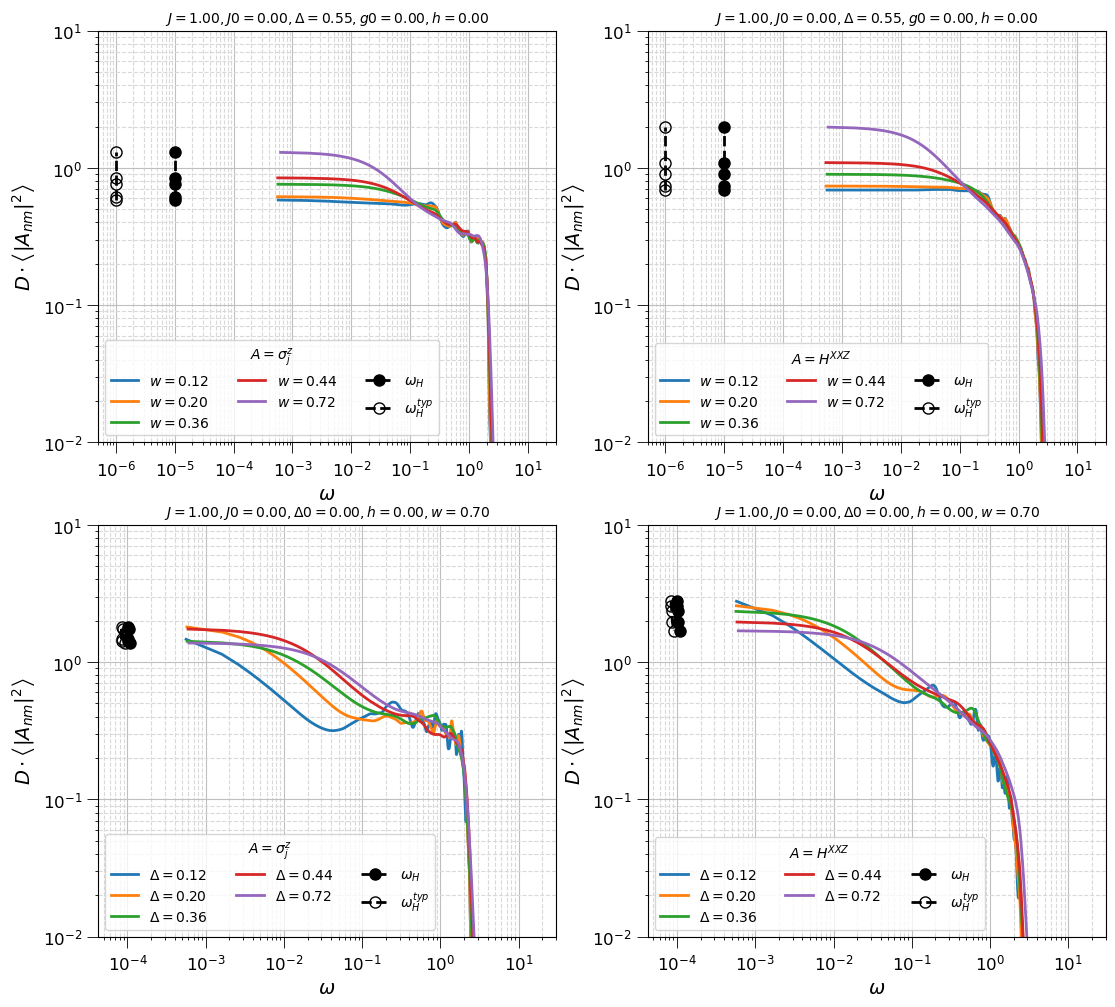

In [ ]:
reload_modules()
import scipy.integrate as integrate
x0 = 0.4
xend = 1.0
dx = 0.1
vals = hfun.get_scaling_array(user_settings, x0, xend, dx)
vals = np.array([0.12, 0.2, 0.36, 0.44, 0.72])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(13,12), dpi = 100)

cut_off_large_omega = 0

def temporary_plot_spec(axis, operatorr, settings):
    wH = [];    LTA = []
    wH_typ = [];    val_at_typ = [];
    omegas = np.logspace(-5, 0, 1000)
    for x in vals:                    
        status, xdata, ydata, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                        settings=settings, 
                                                        parameter=x,
                                                        spec="spec",
                                                        func_x=lambda x, a: x,
                                                        operator = operatorr,
                                                        site = settings['site']
                                                        )
        if status:
            if cut_off_large_omega:
                ydata = np.array([ydata[i] for i in range(0,len(ydata)) if (xdata[i] < 3.0)])
                xdata = np.array([xdata[i] for i in range(0,len(xdata)) if (xdata[i] < 3.0)])
            ydata = ydata * (2**x / x if settings['scaling_idx'] == 0 else 2**cf.L / cf.L) # rescale by D                                                    
            if np.isnan(wHnow):
                wHnow = 1e-5
                wHtypnow = 1e-6
            p = axis.plot(xdata, ydata,label=hfun.key_title(x, settings), linewidth=2, markersize=6)
            "mean";     wH.append(wHnow);           idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHnow));     LTA.append(ydata[idx])
            "typical";  wH_typ.append(wHtypnow);    idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - wHtypnow));  val_at_typ.append(ydata[idx])

            "lorentzian only with cut off"
            if cut_off_large_omega:
                new_set_class = copy.deepcopy(cf.plot_settings)
                new_set_class.set_vs(settings['scaling'])
                new_set_class.set_scaling('L')
                tau_data = []
                status = False
                try :
                    tau_data = thouless.load(getattr(new_set_class, 'settings'))
                    status = True
                except OSError:
                    print("No Thouless data present")
                x_for_tau = []
                taus = []
                if status:    
                    idx = list(tau_data[0]).index(cf.L)
                    x_for_tau = tau_data[1][idx]
                    taus = tau_data[2][idx]
                idx = min(range(len(x_for_tau)), key=lambda i: abs(x_for_tau[i] - x))
                factor = 1
                tau = factor * taus[idx]
                norm = integrate.simpson(y=ydata, x=xdata)
                axis.plot(omegas, ydata[0] / (1 + (omegas * tau)**2 ), color=p[0].get_color(), linestyle='--')
    
    #axis.plot(omegas, 0.4 / (omegas)**0.5, linestyle='--', color='red', label=r"$\omega^{-0.5}$") 
    #axis.plot(omegas, 0.1 / (omegas)**0.75, linestyle='--', color='black', label=r"$\omega^{-0.75}$")        
    hfun.set_plot_elements(axis = axis, ylabel = "D\\cdot\\left\\langle|A_{nm}|^2\\right\\rangle", xlabel = "\\omega", settings=settings, font_size=12, set_legend=False, xlim=(None, None), ylim=(None, None))
    axis.set_xscale('log')
    axis.set_yscale('log')
    x_min = 0.5 * min(wH_typ)
    if cut_off_large_omega: axis.set_xlim(x_min, 3e0)
    else: axis.set_xlim(x_min, 3e1)
    axis.set_ylim(1e-2, 1e1)
    axis.grid(b=True, which='major', color='0.75', linestyle='-')
    axis.grid(b=True, which='minor', color='0.85', linestyle='--')
    #add_legend(axis=axis)
    
    axis.plot(wH, LTA, linestyle='--', marker='o', color='black', linewidth=2, markersize=8, label=r"$\omega_H$")
    axis.plot(wH_typ, val_at_typ, linestyle='--', marker='o', color='black', markerfacecolor='None', linewidth=2, markersize=8, label=r"$\omega_H^{typ}$")
    
    try:
        idx = (cf.operator_formuals[operatorr][2:]).index("=")
        leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr][0:idx] + "$", loc='lower left', ncol=3)
    except ValueError:
        leg = axis.legend(title=r"$A=$"+cf.operator_formuals[operatorr], loc='lower left', ncol=3)

    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])
    axis.title.set_fontsize(10)

cf.set_params(_g=0.55)
temporary_plot_spec(axis=ax1, operatorr=0, settings=user_settings)
temporary_plot_spec(axis=ax2, operatorr=2, settings=user_settings)

cf.set_params(_w=0.7)
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_scaling("g")
settings = getattr(new_set_class, 'settings')
temporary_plot_spec(axis=ax3, operatorr=0, settings=settings)
temporary_plot_spec(axis=ax4, operatorr=2, settings=settings)

### 1-panel single disorder

In [ ]:
w = 1.0
L = 14

status2, xdata2, ydata2, wHnow, wHtypnow = spec_fun.load_spectral(dir=spec_dir, 
                                                                    settings=user_settings, 
                                                                    parameter=x,
                                                                    spec="spec",
                                                                    normalise=True,
                                                                    operator=0
                                                                    )